In [1]:
import numpy as np
import sklearn.datasets
from sklearn.model_selection import train_test_split
import torch
from controller import Controller
from torch.utils import data
import matplotlib.pyplot as plt
import pickle as pkl
import math

In [2]:
class Dataset(data.Dataset):
    def __init__(self, X, y):
        self.X = torch.Tensor(X)
        self.y = torch.Tensor(y)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [3]:
def load_dataset(p_val=0.1, p_test=0.2, noise=0.2):
    np.random.seed(0)
    num_samples = 1000
    X, y = sklearn.datasets.make_moons(num_samples, noise=noise)

    train_end = int(len(X)*(1-p_val-p_test))
    val_end = int(len(X)*(1-p_test))

    ds_train = Dataset(X[:train_end], y[:train_end])
    ds_dev = Dataset(X[train_end:val_end], y[train_end:val_end])
    ds_test = Dataset(X[val_end:], y[val_end:])

    dl_train = data.DataLoader(ds_train, batch_size=32, shuffle=True)
    dl_dev = data.DataLoader(ds_dev, batch_size=32, shuffle=True)
    dl_test = data.DataLoader(ds_test, batch_size=32, shuffle=True)

    return dl_train, dl_dev, dl_test, X, y

In [4]:
dl_train, dl_dev, dl_test, X, y = load_dataset(noise=0.07)
controller = Controller()
num_rollouts = 1000

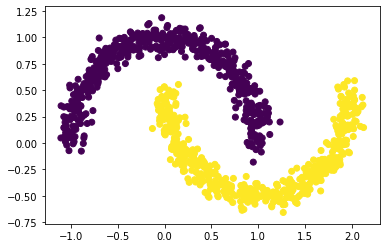

In [5]:
plt.scatter(x=X[:,0], y=X[:,1], c=y)

In [6]:
PATH = 'controller.hd'
rewards = list()
losses = list()
best_loss = math.inf

In [7]:
print('Training controller...')

for i in range(num_rollouts):
    reward = controller.generate_rollout(dl_train, dl_dev)
    loss = controller.optimize()
    controller.beta *= 0.99

    rewards.append(reward)
    losses.append(loss)

    if i % 100 == 0 and i > 0:
        print(f'Rollout {i}, mean reward: {np.mean(rewards[-100:])}, beta: {controller.beta}, loss: {np.mean(losses[-100:])}')
    
    if best_loss>abs(loss):
        torch.save({
            'epoch': i,
            'model_state_dict': controller.state_dict(),
            'optimizer_state_dict': controller.optimizer.state_dict(),
            'loss': loss,
            }, PATH)
        
        best_loss = abs(loss)
        print(f'Model save with loss {loss} at rollout{i}')
        
with open('rewards_losses.pkl', 'wb') as handle:
    pkl.dump((rewards, losses), handle, protocol=pkl.HIGHEST_PROTOCOL)


Training controller...
Model save with loss 0.2956615388393402 at rollout0
Model save with loss -0.20722220838069916 at rollout8
Model save with loss 0.19900274276733398 at rollout98
Model save with loss 0.19039972126483917 at rollout99
Rollout 100, mean reward: 0.621328125, beta: 0.0036237201786049693, loss: 1.0295839324593543
Model save with loss 0.1662420779466629 at rollout101
Model save with loss 0.15489189326763153 at rollout102
Model save with loss 0.12330519407987595 at rollout104
Model save with loss 0.11586010456085205 at rollout106
Model save with loss 0.09852377325296402 at rollout107
Model save with loss 0.09634464979171753 at rollout108
Model save with loss 0.08515206724405289 at rollout109
Model save with loss 0.07085411995649338 at rollout110
Model save with loss 0.060906097292900085 at rollout112
Model save with loss 0.058102454990148544 at rollout115
Model save with loss 0.0550030954182148 at rollout117
Model save with loss 0.05176926031708717 at rollout118
Model save

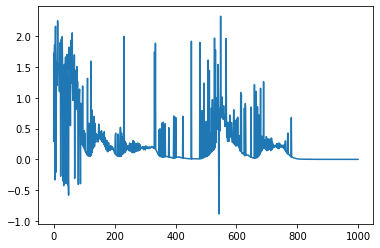

In [8]:
plt.plot(range(len(losses)), losses)

In [9]:
rewards = list()
losses = list()

#### Load the model and try it again on more complex dataset

In [10]:
dl_train, dl_dev, dl_test, X, y = load_dataset(noise=0.4)
controller = Controller()

checkpoint = torch.load(PATH)
controller.load_state_dict(checkpoint['model_state_dict'])
controller.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']

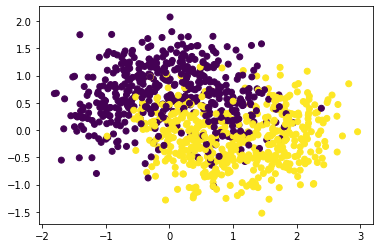

In [11]:
plt.scatter(x=X[:,0], y=X[:,1], c=y)

In [12]:
print('Pre-Training controller...')

for i in range(num_rollouts):
    reward = controller.generate_rollout(dl_train, dl_dev)
    loss = controller.optimize()
    controller.beta *= 0.99

    rewards.append(reward)
    losses.append(loss)

    if i % 100 == 0 and i > 0:
        print(f'Rollout {i}, mean reward: {np.mean(rewards[-100:])}, beta: {controller.beta}, loss: {np.mean(losses[-100:])}')
    
    if best_loss>abs(loss):
        torch.save({
            'epoch': i,
            'model_state_dict': controller.state_dict(),
            'optimizer_state_dict': controller.optimizer.state_dict(),
            'loss': loss,
            }, PATH)
        
        best_loss = abs(loss)
        print(f'Model save with loss {loss} at rollout{i}')
        
with open('rewards_losses.pkl', 'wb') as handle:
    pkl.dump((rewards, losses), handle, protocol=pkl.HIGHEST_PROTOCOL)


Pre-Training controller...
Model save with loss 0.000359461409971118 at rollout0
Model save with loss 0.00035643481533043087 at rollout2
Model save with loss 0.00034428772050887346 at rollout8
Model save with loss 0.00034174148458987474 at rollout10
Model save with loss 0.00031740122358314693 at rollout31
Model save with loss 0.0002875184582080692 at rollout36
Model save with loss 0.0002873143821489066 at rollout60
Model save with loss 0.0002865418209694326 at rollout64
Model save with loss 0.0002743554359767586 at rollout77
Model save with loss 0.00024249345005955547 at rollout91
Rollout 100, mean reward: 0.8359375, beta: 0.0036237201786049693, loss: 0.000331951715197647
Model save with loss 0.0002349419955862686 at rollout101
Model save with loss 0.00022831121168565005 at rollout135
Model save with loss 0.00022330338833853602 at rollout142
Model save with loss 0.00021921492589171976 at rollout148
Model save with loss 0.00021852977806702256 at rollout149
Model save with loss 0.0002159

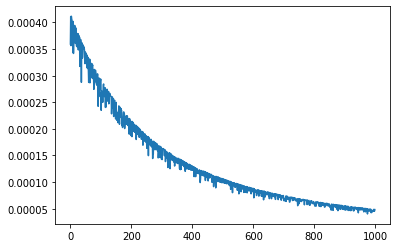

In [13]:
plt.plot(range(len(losses)), losses)